In [1]:
from astropy.table import Table
from matplotlib import pyplot as plt
%matplotlib inline
import os
import numpy as np
from astropy.io.ascii import masked
from astropy.coordinates import Angle
from astropy.io import ascii
import glob
from astropy.io import fits
import wget
import matplotlib.image as mpimg
from astropy.wcs import WCS
from scipy.stats import scoreatpercentile
from astropy.visualization import simple_norm
from reproject import reproject_interp
import sys
from IPython.display import clear_output
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import ImageNormalize
from astropy.visualization import LogStretch
from astropy.wcs import WCS
import astropy.units as u
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import Angle
from scipy import stats
from astropy.visualization import MinMaxInterval
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.stats import gaussian_sigma_to_fwhm

from astropy.nddata import CCDData
import warnings
warnings.filterwarnings('ignore')

mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

#define an empty dictionary that will contain the EllipseGeometry instance
geometry = {}
initparams = {}
#initialize dictionary for half-light radii
rhalfpix = {}
rhalfasec = {}
from photutils.isophote import Ellipse
from photutils import aperture_photometry
#initialize dictionary for ellipse fitting
ellipse = {}
isolist = {}

In [2]:
#Set the home path

os.environ['HOME'] ='C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir+'/Virgo/tables'
plotdir = homedir+'/Virgo/plots'
datadir = homedir+'/HTML-building/galaxy'

In [3]:
def find_files(destination_folder, partial_name):
    matching_files = []

    for root, dirs, files in os.walk(destination_folder):
        for file in files:
            if partial_name.lower() in file.lower():
                matching_files.append(os.path.join(root, file))

    return matching_files 
def aperture(data):
        '''
        # rmax is max radius to measure ellipse
        # could cut this off based on SNR
        # or could cut this off based on enclosed flux?
        # or could cut off based on image dimension, and do the cutting afterward
        
        #rmax = 2.5*self.sma
        '''
        # rmax is set according to the image dimensions
        # look for where the semi-major axis hits the edge of the image
        # could by on side (limited by x range) or on top/bottom (limited by y range)
        # 
        yimage_max, ximage_max = data.shape
        
        rmax = np.min([(ximage_max - x0)/abs(np.cos(PAN)),\
                        (yimage_max - y0)/abs(np.sin(PAN))])
        index = np.arange(80)
        apertures = (index+1)*.5*.7*(1+(index+1)*.1)
        # cut off apertures at edge of image
        apertures_a = apertures[apertures < rmax]
        return apertures_a
def imdisplay(image,x,y,sma,ellip,pa, v1perc=10, v2perc=95, logscale=True):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    print(v1,v2)
    norm = None
    if (logscale):
        norm = ImageNormalize(vmin=v1, vmax=v2, stretch=LogStretch())
    else:
        norm = ImageNormalize(vmin=v1, vmax=v2)
    im = ax.imshow(image, origin='lower', norm=norm)
    aper = EllipticalAperture((x, y), sma,
                              (ellip)*sma, pa)
    plt.axis('off')    
    aper.plot(color='red')
    return fig,ax
    #fig.colorbar(fraction=.08)
def measure_phot(data, apertures_a):
        apertures_b = (1.-EPLI)*apertures_a
        area = np.pi*apertures_a*apertures_b # area of each ellipse

        flux1 = np.zeros(len(apertures_a),'f')
        allellipses = []
        for i in range(len(apertures_a)):
            # EllipticalAperture takes rotation angle in radians, CCW from +x axis
            ap = EllipticalAperture((x0, y0),apertures_a[i],apertures_b[i],PAN)#,ai,bi,theta) for ai,bi in zip(a,b)]
            allellipses.append(ap)
                    # subpixel is the method used by Source Extractor
            phot_table1 = aperture_photometry(data, ap, method = 'subpixel', 
                                                    subpixels=5)
            
            flux1[i] = phot_table1['aperture_sum'][0]
            if np.isnan(flux1[i]):
                break
        # first aperture is calculated differently
        sb1 = np.zeros(len(apertures_a),'f')
        flux1 = flux1 / pixscale #convert the units of the flux from Jy/pix to Jy/arcsec)
        sb1[0] = flux1[0]/area[0]
        # outer apertures need flux from inner aperture subtracted
        for i in range(1,len(area)):
            sb1[i] = (flux1[i] - flux1[i-1])/(area[i]-area[i-1])    
        valid_indices = ~np.isnan(sb1) & ~np.isnan(flux1) & (sb1 != 0) & (flux1 != 0)
        sb1 = sb1[valid_indices]
        flux1 = flux1[valid_indices]
        apertures_a = apertures_a[valid_indices]
        flux1_err = np.zeros(len(apertures_a),'f')
        sb1_err = np.zeros(len(apertures_a),'f')
        print('Number of apertures for',wave ,'microns band = ',len(apertures_a))
        # Find the maximum values
        sb1max = np.max(sb1)
        flux1max = np.max(flux1)
        arcsec_apt = apertures_a * pixscale
        apertures_ahalf1 = np.max(arcsec_apt) / 2
        total_apt = len(apertures_a)
        return sb1, flux1, sb1max, flux1max, apertures_ahalf1, flux1_err, sb1_err, apertures_a, arcsec_apt, total_apt

def plot_profilesbgr(sb1, sb1_err, flux1, flux1_err, ap1,sb2, sb2_err, flux2, flux2_err, ap2 ,sb3, sb3_err, flux3, flux3_err, ap3,flux_yscale='log'):
        ''' enclosed flux and surface brightness profiles, save figure '''
        
        plt.close("all")        
        plt.figure(figsize=(10,4))
        plt.subplots_adjust(wspace=.3)
        plt.subplot(2,4,1)
        plt.errorbar(ap1,flux1,
                     flux1_err,fmt='b.')
        plt.title('70 microns')
        plt.ylabel('Flux (Jy/arcsec)')
        if flux_yscale=='log':
            plt.gca().set_yscale('log')
        
        plt.subplot(2,4,2)
        plt.errorbar(ap2,flux2,
                     flux2_err,fmt='g.')
        plt.title('100 microns')
        if flux_yscale=='log':
            plt.gca().set_yscale('log')
        plt.subplot(2,4,3)
        plt.errorbar(ap3,flux3,
                     flux3_err,fmt='r.')
        plt.title('160 microns')
        if flux_yscale=='log':
            plt.gca().set_yscale('log')
        
        plt.subplot(2,4,4)
        label1='Blue'
        label2='Green'
        label3='Red'
        plt.errorbar(ap1, flux1/np.max(flux1), 
                     flux1_err/np.max(flux1_err), fmt='b.',label=label1)
        plt.errorbar(ap2, flux2/np.max(flux2), 
                     flux2_err/np.max(flux2_err), fmt='g.',label=label2)
        plt.errorbar(ap3, flux3/np.max(flux3), 
                     flux3_err/np.max(flux3_err), fmt='r.',label=label3)
        plt.title('Normalized Curves')
        if flux_yscale=='log':
            plt.gca().set_yscale('log')
        plt.legend()
        
        plt.subplot(2,4,5)
        plt.errorbar(ap1,sb1,sb1_err,fmt='b.')
        plt.ylabel('Surface Brightness')
        plt.xlabel('Semi-Major Axis [arcsec]')
        plt.gca().set_yscale('log')
        
        plt.subplot(2,4,6)
        plt.errorbar(ap2,sb2,
                     sb2_err,fmt='g.')
        plt.xlabel('Semi-Major Axis [arcsec]')
        plt.gca().set_yscale('log')

        plt.subplot(2,4,7)
        plt.errorbar(ap3,sb3,
                     sb3_err,fmt='r.')
        plt.xlabel('Semi-Major Axis [arcsec]')
        plt.gca().set_yscale('log')
    
        plt.subplot(2,4,8)
        plt.errorbar(ap1, sb1/np.max(sb1), 
                     sb1_err/np.max(sb1_err), fmt='b.')
        plt.errorbar(ap2, sb2/np.max(sb2), 
                     sb2_err/np.max(sb2_err), fmt='g.')
        plt.errorbar(ap3, sb3/np.max(sb3), 
                     sb3_err/np.max(sb3_err), fmt='r.')
        plt.gca().set_yscale('log')
        plt.xlabel('Semi-Major Axis [arcsec]')
        
        plt.savefig(datadir+'/photometry/'+VFID+'-'+galaxy_name+'.png', dpi=150)
        plt.close()
        
def plot_profilesbr(sb1, sb1_err, flux1, flux1_err, ap1,sb3, sb3_err, flux3, flux3_err, ap3,flux_yscale='log'):
        ''' enclosed flux and surface brightness profiles, save figure '''
        
        plt.close("all")        
        plt.figure(figsize=(10,4))
        plt.subplots_adjust(wspace=.3)
        
        plt.subplot(2,3,1)
        plt.errorbar(ap1,flux1,
                     flux1_err,fmt='b.')
        plt.title('70 microns')
        plt.ylabel('Flux (Jy/arcsec)')
        if flux_yscale=='log':
            plt.gca().set_yscale('log')
        
        plt.subplot(2,3,2)
        plt.errorbar(ap3,flux3,
                     flux3_err,fmt='r.')
        plt.title('160 microns')
        if flux_yscale=='log':
            plt.gca().set_yscale('log')
        
        plt.subplot(2,3,3)
        label1='Blue'
        label2='Red'
        plt.errorbar(ap1, flux1/np.max(flux1), 
                     flux1_err/np.max(flux1_err), fmt='b.',label=label1)
        plt.errorbar(ap3, flux3/np.max(flux3), 
                     flux3_err/np.max(flux3_err), fmt='r.',label=label2)
        plt.title('Normalized Curves')
        if flux_yscale=='log':
            plt.gca().set_yscale('log')
        plt.legend()
        
        plt.subplot(2,3,4)
        plt.errorbar(ap1,sb1,sb1_err,fmt='b.')
        plt.ylabel('Surface Brightness')
        plt.xlabel('Semi-Major Axis [arcsec]')
        plt.gca().set_yscale('log')
        

        plt.subplot(2,3,5)
        plt.errorbar(ap3,sb3,
                     sb3_err,fmt='r.')
        plt.xlabel('Semi-Major Axis [arcsec]')
        plt.gca().set_yscale('log')
    
        plt.subplot(2,3,6)
        plt.errorbar(ap1, sb1/np.max(sb1), 
                     sb1_err/np.max(sb1_err), fmt='b.')
        plt.errorbar(ap3, sb3/np.max(sb3), 
                     sb3_err/np.max(sb3_err), fmt='r.')
        plt.gca().set_yscale('log')
        plt.xlabel('Semi-Major Axis [arcsec]')
        
        plt.savefig(datadir+'/photometry/'+VFID+'-'+galaxy_name+'.png', dpi=150)
        plt.close()
def plot_profilesgr(sb2, sb2_err, flux2, flux2_err, ap2,sb3, sb3_err, flux3, flux3_err, ap3,flux_yscale='log'):
        ''' enclosed flux and surface brightness profiles, save figure '''
        
        plt.close("all")        
        plt.figure(figsize=(10,4))
        plt.subplots_adjust(wspace=.3)
        
        plt.subplot(2,3,1)
        plt.errorbar(ap2,flux2,
                     flux2_err,fmt='g.')
        plt.title('100 microns')
        plt.ylabel('Flux (Jy/arcsec)')
        if flux_yscale=='log':
            plt.gca().set_yscale('log')
        
        plt.subplot(2,3,2)
        plt.errorbar(ap3,flux3,
                     flux3_err,fmt='r.')
        plt.title('160 microns')
        if flux_yscale=='log':
            plt.gca().set_yscale('log')
        
        plt.subplot(2,3,3)
        label1='Green'
        label2='Red'
        plt.errorbar(ap2, flux2/np.max(flux2), 
                     flux2_err/np.max(flux2_err), fmt='g.',label=label1)
        plt.errorbar(ap3, flux3/np.max(flux3), 
                     flux3_err/np.max(flux3_err), fmt='r.',label=label2)
        plt.title('Normalized Curves')
        if flux_yscale=='log':
            plt.gca().set_yscale('log')
        plt.legend()
        
        plt.subplot(2,3,4)
        plt.errorbar(ap2,sb2,sb2_err,fmt='g.')
        plt.ylabel('Surface Brightness')
        plt.xlabel('Semi-Major Axis [arcsec]')
        plt.gca().set_yscale('log')
        

        plt.subplot(2,3,5)
        plt.errorbar(ap3,sb3,
                     sb3_err,fmt='r.')
        plt.xlabel('Semi-Major Axis [arcsec]')
        plt.gca().set_yscale('log')
    
        plt.subplot(2,3,6)
        plt.errorbar(ap2, sb2/np.max(sb2), 
                     sb2_err/np.max(sb2_err), fmt='g.')
        plt.errorbar(ap3, sb3/np.max(sb3), 
                     sb3_err/np.max(sb3_err), fmt='r.')
        plt.gca().set_yscale('log')
        plt.xlabel('Semi-Major Axis [arcsec]')
        
        plt.savefig(datadir+'/photometry/'+VFID+'-'+galaxy_name+'.png', dpi=150)
        plt.close()

In [19]:
#general photometry for the herschel matches
csv_file = tabledir+'/Photometrytesting.csv'
galaxy = Table.read(csv_file)
# Determine the length of the galaxy
galaxy_length = len(galaxy)
# Assign zeros to the variables
sb3max = np.zeros(galaxy_length, dtype='f')
flux3max = np.zeros(galaxy_length, dtype='f')
apertures_ahalf3 = np.zeros(galaxy_length, dtype='f')
num_apt3 = np.zeros(galaxy_length, dtype='f')
sb3max = np.zeros(galaxy_length, dtype='f')
sb2max = np.zeros(galaxy_length, dtype='f')
flux2max = np.zeros(galaxy_length, dtype='f')
apertures_ahalf2 = np.zeros(galaxy_length, dtype='f')
num_apt2 = np.zeros(galaxy_length, dtype='f')
sb1max = np.zeros(galaxy_length, dtype='f')
flux1max = np.zeros(galaxy_length, dtype='f')
apertures_ahalf1 = np.zeros(galaxy_length, dtype='f')
num_apt1 = np.zeros(galaxy_length, dtype='f')
for i in range(len(galaxy)):
    galaxy_name = str(galaxy['GALAXY'][i])
    RA = galaxy['RA_MOMENT'][i]
    DEC = galaxy['DEC_MOMENT'][i]
    EPLI = galaxy['BA_MOMENT'][i]
    PAN = (galaxy['PA_MOMENT'][i] + 90) * np.pi/180
    SMAO = galaxy['SMA_AP06'][i]
    path =  datadir+'/pipeline/'+galaxy_name
    VFID = str(galaxy['VFID'][i])
    if os.path.exists(path):
        hasblue = False
        hasgreen = False
        hasred = False
        destination_folder = path+'\\HPPUNIMAPR'
        partial_name = 'hpacs_25HPPUNIMAPR'
        found_files3 = find_files(destination_folder, partial_name)
        if found_files3:
            found_file3 = found_files3[0]
            placeholder = fits.open(found_file3)
            pixscale = placeholder[0].header['PIXSIZE']
            wave = placeholder[0].header['WAVELNTH']
            SMAN = (SMAO * 0.262) / pixscale
            data, header = fits.getdata(found_file3, header=True)
            wcs = WCS(header)
            x0, y0 = wcs.all_world2pix(RA, DEC, 0)
            initparams[galaxy_name] = {}
            initparams[galaxy_name]['xcen'] = x0
            initparams[galaxy_name]['ycen'] = y0
            initparams[galaxy_name]['sma'] = SMAN
            initparams[galaxy_name]['ellip'] = EPLI
            initparams[galaxy_name]['PA'] = PAN
            aperture_a = aperture(data)
            hasred = True
            sb3, flux3, sb3max[i], flux3max[i], apertures_ahalf3[i], sb3_err, flux3_err, n_ap3, arcsec_apt3, num_apt3[i] = measure_phot(data, aperture_a)
        destination_folder = path+'\\HPPUNIMAPB'
        partial_name = 'hpacs_25HPPUNIMAPB'
        found_files1 = find_files(destination_folder, partial_name)
        if found_files1:
            found_file1 = found_files1[0]
            placeholder = fits.open(found_file1)
            pixscale = placeholder[0].header['PIXSIZE']
            wave = placeholder[0].header['WAVELNTH']
            SMAN = (SMAO * 0.262) / pixscale
            data, header = fits.getdata(found_file1, header=True)
            wcs = WCS(header)
            x0, y0 = wcs.all_world2pix(RA, DEC, 0)
            initparams[galaxy_name] = {}
            initparams[galaxy_name]['xcen'] = x0
            initparams[galaxy_name]['ycen'] = y0
            initparams[galaxy_name]['sma'] = SMAN
            initparams[galaxy_name]['ellip'] = EPLI
            initparams[galaxy_name]['PA'] = PAN
            hasblue = True
            sb1, flux1, sb1max[i], flux1max[i], apertures_ahalf1[i], sb1_err, flux1_err, n_ap1, arcsec_apt1, num_apt1[i] = measure_phot(data, aperture_a)            
        destination_folder = path+'\\HPPUNIMAPG'
        partial_name = 'hpacs_25HPPUNIMAPB'
        found_files2 = find_files(destination_folder, partial_name)
        if found_files2:
            found_file2 = found_files2[0]
            placeholder = fits.open(found_file2)
            pixscale = placeholder[0].header['PIXSIZE']
            wave = placeholder[0].header['WAVELNTH']
            SMAN = (SMAO * 0.262) / pixscale
            data, header = fits.getdata(found_file2, header=True)
            wcs = WCS(header)
            x0, y0 = wcs.all_world2pix(RA, DEC, 0)
            initparams[galaxy_name] = {}
            initparams[galaxy_name]['xcen'] = x0
            initparams[galaxy_name]['ycen'] = y0
            initparams[galaxy_name]['sma'] = SMAN
            initparams[galaxy_name]['ellip'] = EPLI
            initparams[galaxy_name]['PA'] = PAN
            hasgreen = True
            sb2, flux2, sb2max[i], flux2max[i], apertures_ahalf2[i], sb2_err, flux2_err, n_ap2, arcsec_apt2, num_apt2[i] = measure_phot(data, aperture_a)    
        if hasblue == True & hasgreen == True:
            max_shared_value = min(max(arcsec_apt1), max(arcsec_apt2), max(arcsec_apt3))

            # Find indices where the values are below the max_shared_value
            indices_1 = [i for i, value in enumerate(arcsec_apt1) if value < max_shared_value]
            indices_2 = [i for i, value in enumerate(arcsec_apt2) if value < max_shared_value]
            indices_3 = [i for i, value in enumerate(arcsec_apt3) if value < max_shared_value]

            # Truncate all arrays to the indices where values are below max_shared_value
            sb1 = [sb1[i] for i in indices_1]
            sb1_err = [sb1_err[i] for i in indices_1]
            flux1 = [flux1[i] for i in indices_1]
            flux1_err = [flux1_err[i] for i in indices_1]
            arcsec_apt1 = [arcsec_apt1[i] for i in indices_1]

            sb2 = [sb2[i] for i in indices_2]
            sb2_err = [sb2_err[i] for i in indices_2]
            flux2 = [flux2[i] for i in indices_2]
            flux2_err = [flux2_err[i] for i in indices_2]
            arcsec_apt2 = [arcsec_apt2[i] for i in indices_2]

            sb3 = [sb3[i] for i in indices_3]
            sb3_err = [sb3_err[i] for i in indices_3]
            flux3 = [flux3[i] for i in indices_3]
            flux3_err = [flux3_err[i] for i in indices_3]
            arcsec_apt3 = [arcsec_apt3[i] for i in indices_3]
            plot_profilesbgr(sb1, sb1_err, flux1, flux1_err, arcsec_apt1,sb2, sb2_err, flux2, flux2_err, arcsec_apt2,sb3, sb3_err, flux3, flux3_err, arcsec_apt3,flux_yscale='log')
        if hasblue and not hasgreen:
            max_shared_value = min(max(arcsec_apt1), max(arcsec_apt3))

            # Find indices where the values are below the max_shared_value
            indices_1 = [i for i, value in enumerate(arcsec_apt1) if value < max_shared_value]
            indices_3 = [i for i, value in enumerate(arcsec_apt3) if value < max_shared_value]

            # Truncate all arrays to the indices where values are below max_shared_value
            sb1 = [sb1[i] for i in indices_1]
            sb1_err = [sb1_err[i] for i in indices_1]
            flux1 = [flux1[i] for i in indices_1]
            flux1_err = [flux1_err[i] for i in indices_1]
            arcsec_apt1 = [arcsec_apt1[i] for i in indices_1]

            sb3 = [sb3[i] for i in indices_3]
            sb3_err = [sb3_err[i] for i in indices_3]
            flux3 = [flux3[i] for i in indices_3]
            flux3_err = [flux3_err[i] for i in indices_3]
            arcsec_apt3 = [arcsec_apt3[i] for i in indices_3]
            plot_profilesbr(sb1, sb1_err, flux1, flux1_err, arcsec_apt1,sb3, sb3_err, flux3, flux3_err, arcsec_apt3,flux_yscale='log')  
        if not hasblue and hasgreen:
            max_shared_value = min(max(arcsec_apt2), max(arcsec_apt3))

            # Find indices where the values are below the max_shared_value
            indices_2 = [i for i, value in enumerate(arcsec_apt2) if value < max_shared_value]
            indices_3 = [i for i, value in enumerate(arcsec_apt3) if value < max_shared_value]

            # Truncate all arrays to the indices where values are below max_shared_value

            sb2 = [sb2[i] for i in indices_2]
            sb2_err = [sb2_err[i] for i in indices_2]
            flux2 = [flux2[i] for i in indices_2]
            flux2_err = [flux2_err[i] for i in indices_2]
            arcsec_apt2 = [arcsec_apt2[i] for i in indices_2]

            sb3 = [sb3[i] for i in indices_3]
            sb3_err = [sb3_err[i] for i in indices_3]
            flux3 = [flux3[i] for i in indices_3]
            flux3_err = [flux3_err[i] for i in indices_3]
            arcsec_apt3 = [arcsec_apt3[i] for i in indices_3]
            plot_profilesgr(sb2, sb2_err, flux2, flux2_err, arcsec_apt2,sb3, sb3_err, flux3, flux3_err, arcsec_apt3,flux_yscale='log') 
    else:
        print(f"Galaxy not found: {VFID}")
        print(galaxy_name)
print('done')

Number of apertures for 160.0 microns band =  30
Number of apertures for 70.0 microns band =  40
Number of apertures for 100.0 microns band =  40
Number of apertures for 160.0 microns band =  33
Number of apertures for 70.0 microns band =  37
Number of apertures for 100.0 microns band =  38
Number of apertures for 160.0 microns band =  59
Number of apertures for 70.0 microns band =  72
Number of apertures for 100.0 microns band =  72
Number of apertures for 160.0 microns band =  41
Number of apertures for 70.0 microns band =  45
Number of apertures for 100.0 microns band =  45
Number of apertures for 160.0 microns band =  57
Number of apertures for 70.0 microns band =  61
Number of apertures for 100.0 microns band =  57
Number of apertures for 160.0 microns band =  57
Number of apertures for 100.0 microns band =  62
Number of apertures for 160.0 microns band =  51
Number of apertures for 100.0 microns band =  71
Number of apertures for 160.0 microns band =  39
Number of apertures for 1

In [4]:
#ellipse generation for the herschel matches
csv_file = tabledir+'/Photometrytesting.csv'
csv_file2 = tabledir+'/Herschelstuff.csv'
galaxy = Table.read(csv_file)
galaxy2 = Table.read(csv_file2)
galaxy['70Flux_AP06'] = np.zeros(len(galaxy))
galaxy['100Flux_AP06'] = np.zeros(len(galaxy))
galaxy['160Flux_AP06'] = np.zeros(len(galaxy))
# Determine the length of the galaxy
galaxy_length = len(galaxy)
ap06fluxblue = np.zeros(galaxy_length, dtype='f')
ap06fluxgreen = np.zeros(galaxy_length, dtype='f')
ap06fluxred = np.zeros(galaxy_length, dtype='f')
for i in range(len(galaxy)):
    galaxy_name = str(galaxy['GALAXY'][i])
    RA = galaxy['RA_MOMENT'][i]
    DEC = galaxy['DEC_MOMENT'][i]
    EPLI = galaxy['BA_MOMENT'][i]
    PAN = (galaxy['PA_MOMENT'][i] + 90) * np.pi/180
    SMAO = galaxy['SMA_MOMENT'][i]
    path =  datadir+'/pipeline/'+galaxy_name
    VFID = str(galaxy2['vfid_01'][i])
    if os.path.exists(path):
        destination_folder = path+'\\HPPUNIMAPB'
        partial_name = 'hpacs_25HPPUNIMAPB'
        found_files = find_files(destination_folder, partial_name)
        if found_files:
            found_file = found_files[0]
            placeholder = fits.open(found_file)
            pixscale = placeholder[0].header['PIXSIZE']
            wave = placeholder[0].header['WAVELNTH']
            SMAN = (SMAO * 0.262) / pixscale
            data, header = fits.getdata(found_file, header=True)
            wcs = WCS(header)
            x0, y0 = wcs.all_world2pix(RA, DEC, 0)
            initparams[galaxy_name] = {}
            initparams[galaxy_name]['xcen'] = x0
            initparams[galaxy_name]['ycen'] = y0
            initparams[galaxy_name]['sma'] = SMAN
            initparams[galaxy_name]['ellip'] = EPLI
            initparams[galaxy_name]['PA'] = PAN
            fig,ax = plt.subplots(figsize=(10,10))
            nimage = np.array(data)
            v1 = None
            v2 = None
            for v1perc in np.arange(0.1, 40.0, 0.1):
                v1 = scoreatpercentile(nimage, v1perc)
                if v1 > 0:
                    break
            for v2perc in np.arange(99.9, 20.0, -0.1):
                v2 = scoreatpercentile(nimage, v2perc)
                if not np.isnan(v2):
                    break
            imdisplay(data,x0,y0,SMAN,EPLI,PAN,v1perc,v2perc,logscale=True)
            aper = EllipticalAperture((initparams[galaxy_name]['xcen'], initparams[galaxy_name]['ycen']), initparams[galaxy_name]['sma'],
                              (1.-initparams[galaxy_name]['ellip'])*initparams[galaxy_name]['sma'], initparams[galaxy_name]['PA'])
            phot_table = aperture_photometry(data, aper)
            ap06fluxblue[i] = phot_table['aperture_sum'][0]  #/ pixscale
            print(galaxy_name+' 70 '+str(ap06fluxblue[i]))
            galaxy['70Flux_AP06'][i] = ap06fluxblue[i]
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.savefig(datadir+'/photometry/'+VFID+'-'+galaxy_name+'blue-AP06.png', dpi=150)
            plt.close()
        destination_folder = path+'\\HPPUNIMAPG'
        partial_name = 'hpacs_25HPPUNIMAPB'
        found_files = find_files(destination_folder, partial_name)
        if found_files:
            found_file = found_files[0]
            placeholder = fits.open(found_file)
            pixscale = placeholder[0].header['PIXSIZE']
            wave = placeholder[0].header['WAVELNTH']
            SMAN = (SMAO * 0.262) / pixscale
            data, header = fits.getdata(found_file, header=True)
            wcs = WCS(header)
            x0, y0 = wcs.all_world2pix(RA, DEC, 0)
            initparams[galaxy_name] = {}
            initparams[galaxy_name]['xcen'] = x0
            initparams[galaxy_name]['ycen'] = y0
            initparams[galaxy_name]['sma'] = SMAN
            initparams[galaxy_name]['ellip'] = EPLI
            initparams[galaxy_name]['PA'] = PAN
            fig,ax = plt.subplots(figsize=(10,10))
            data, header = fits.getdata(found_file, header=True)
            nimage = np.array(data)
            v1 = None
            v2 = None
            for v1perc in np.arange(0.1, 40.0, 0.1):
                v1 = scoreatpercentile(nimage, v1perc)
                if v1 > 0:
                    break
            for v2perc in np.arange(99.9, 20.0, -0.1):
                v2 = scoreatpercentile(nimage, v2perc)
                if not np.isnan(v2):
                    break
            imdisplay(data,x0,y0,SMAN,EPLI,PAN,v1perc,v2perc,logscale=True)
            aper = EllipticalAperture((initparams[galaxy_name]['xcen'], initparams[galaxy_name]['ycen']), initparams[galaxy_name]['sma'],
                              (1.-initparams[galaxy_name]['ellip'])*initparams[galaxy_name]['sma'], initparams[galaxy_name]['PA'])
            phot_table = aperture_photometry(data, aper)
            ap06fluxgreen[i] = phot_table['aperture_sum'][0] #/ pixscale
            print(galaxy_name+' 100 '+str(ap06fluxgreen[i]))
            galaxy['100Flux_AP06'][i] = ap06fluxgreen[i]
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.savefig(datadir+'/photometry/'+VFID+'-'+galaxy_name+'green-AP06.png', dpi=150)
            plt.close()
        destination_folder = path+'\\HPPUNIMAPR'
        partial_name = 'hpacs_25HPPUNIMAPR'
        found_files = find_files(destination_folder, partial_name)
        if found_files:
            found_file = found_files[0]
            placeholder = fits.open(found_file)
            pixscale = placeholder[0].header['PIXSIZE']
            wave = placeholder[0].header['WAVELNTH']
            SMAN = (SMAO * 0.262) / pixscale
            data, header = fits.getdata(found_file, header=True)
            wcs = WCS(header)
            x0, y0 = wcs.all_world2pix(RA, DEC, 0)
            initparams[galaxy_name] = {}
            initparams[galaxy_name]['xcen'] = x0
            initparams[galaxy_name]['ycen'] = y0
            initparams[galaxy_name]['sma'] = SMAN
            initparams[galaxy_name]['ellip'] = EPLI
            initparams[galaxy_name]['PA'] = PAN
            fig,ax = plt.subplots(figsize=(10,10))
            data, header = fits.getdata(found_file, header=True)
            nimage = np.array(data)
            v1 = None
            v2 = None
            for v1perc in np.arange(0.1, 40.0, 0.1):
                v1 = scoreatpercentile(nimage, v1perc)
                if v1 > 0:
                    break
            for v2perc in np.arange(99.9, 20.0, -0.1):
                v2 = scoreatpercentile(nimage, v2perc)
                if not np.isnan(v2):
                    break
            imdisplay(data,x0,y0,SMAN,EPLI,PAN,v1perc,v2perc,logscale=True)
            aper = EllipticalAperture((initparams[galaxy_name]['xcen'], initparams[galaxy_name]['ycen']), initparams[galaxy_name]['sma'],
                              (initparams[galaxy_name]['ellip'])*initparams[galaxy_name]['sma'], initparams[galaxy_name]['PA'])
            phot_table = aperture_photometry(data, aper)
            ap06fluxred[i] = phot_table['aperture_sum'][0]  #/ pixscale
            print(galaxy_name+' 160 '+str(ap06fluxred[i]) +'Eppli is'+str(EPLI))
            galaxy['160Flux_AP06'][i] = ap06fluxred[i]
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.savefig(datadir+'/photometry/'+VFID+'-'+galaxy_name+'red-AP06.png', dpi=150)
            plt.close()
    else:
        print(f"Galaxy not found: {VFID}")
        print(galaxy_name)
galaxy.write(tabledir+'/Photometrytesting2.csv', format='csv', overwrite=True)
print('done')

3.887333441525727e-07 0.002143644822172746
NGC4589 70 0.15683958
1.8437698599859428e-08 0.004415528924286796
NGC4589 100 0.24565665
1.6202320111916843e-06 0.008467505295912427
NGC4589 160 0.41160122Eppli is0.7670966386795044
1.346551798633274e-06 0.0038945530511264106
UGC03701 70 0.007987015
7.270683272509694e-07 0.006612272887494178
UGC03701 100 0.016753284
2.790538535919115e-06 0.013737265925265718
UGC03701 160 0.1758443Eppli is0.9195771217346191
8.936662925407295e-07 0.005805858433764745
UGC05423 70 0.09032176
9.70317407336644e-07 0.00657705194038396
UGC05423 100 0.09919005
2.2273379727267737e-06 0.01462531443687808
UGC05423 160 0.12821555Eppli is0.6154758334159851
1.8209806876257074e-06 0.008805164843805186
NGC3622 70 0.7021412
1.1543357977644098e-06 0.009358736664224801
NGC3622 100 1.0748844
1.425415684934768e-06 0.029274988770696606
NGC3622 160 1.3884052Eppli is0.6532043218612671
2.0241237943991833e-06 0.00496682467733323
NGC4125 70 0.85387033
8.344221132574712e-07 0.004814540018

In [7]:
galaxy = Table.read(tabledir+'/Photometrytesting2.csv')
herschel = Table.read(tabledir+'/Herschelstuff.csv')
for i in range(len(galaxy)):
    galaxy_name = str(galaxy['GALAXY'][i])
    path = datadir + '\\pipeline\\' + galaxy_name
    VFID = str(herschel['vfid_01'][i])
    RA = str(galaxy['RA_MOMENT'][i])
    DEC = str(galaxy['DEC_MOMENT'][i])
    filepath = datadir+'/html/'+VFID+'-'+galaxy_name+'.html'
    blueflag = herschel['70micronsflag'][i]
    greenflag = herschel['100micronsflag'][i]
    Flux70 =  str(galaxy['70Flux_AP06'][i])
    Flux100 =  str(galaxy['100Flux_AP06'][i])
    Flux160 =  str(galaxy['160Flux_AP06'][i])
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    # Write the HTML code line by line
    with open(filepath, "w") as html:
        html.write('<html><body>\n')
        html.write('<title>Photometry data</title>\n')
        html.write('<style type="text/css">\n')
        html.write('table, td, th {padding: 5px; text-align: center; border: 2px solid black;}\n')
        html.write('p {display: inline-block;;}\n')
        html.write('</style>\n')
        html.write('<table width="100%"><tr><th>VFID</th><th>Name</th><th>Legacy image</th><th>Herschel-UnimapBlue (70microns)</th><th>Herschel-UnimapBlue (100microns)</th><th>Herschel-UnimapRed (160microns)</th><th>RA</th><th>DEC</th></tr></p>')
        html.write('<tr><td>'+VFID+'</td><td>'+galaxy_name+'</td><td><a href="../png/'+VFID+'-'+galaxy_name+'-LS.jpg"><img src="../png/'+VFID+'-'+galaxy_name+'-LS.jpg" alt="No LS data.jpg" height="auto" width="100%"></a></td><td><a href="../png/'+VFID+'-'+galaxy_name+'blue.png"><img src="../png/'+VFID+'-'+galaxy_name+'blue.png" alt="Missing file 70microns.jpg" height="auto" width="100%"></a></td><td><a href="../png/'+VFID+'-'+galaxy_name+'green.png"><img src="../png/'+VFID+'-'+galaxy_name+'green.png" alt="Missing file 100microns.jpg" height="auto" width="100%"></a></td><td><a href="../png/'+VFID+'-'+galaxy_name+'red.png"><img src="../png/'+VFID+'-'+galaxy_name+'red.png" alt="Missing file 160microns.jpg" height="auto" width="100%"></a></td><td>'+RA+'</td><td>'+DEC+'</td></tr> \n')
        html.write('</table>\n')
        html.write('<h2>AP06 ellipses onto the images</h2>')
        html.write('<table width="100%"><tr><th>Herschel-UnimapBlue (70microns)</th><th>Herschel-UnimapBlue (100microns)</th><th>Herschel-UnimapRed (160microns)</th></tr></p>')
        html.write('<tr><td><a href="../photometry/'+VFID+'-'+galaxy_name+'blue-AP06.png"><img src="../photometry/'+VFID+'-'+galaxy_name+'blue-AP06.png" alt="Missing file 70microns.jpg" height="auto" width="100%"></a></td><td><a href="../photometry/'+VFID+'-'+galaxy_name+'green-AP06.png"><img src="../photometry/'+VFID+'-'+galaxy_name+'green-AP06.png" alt="Missing file 100microns.jpg" height="auto" width="100%"></a></td><td><a href="../photometry/'+VFID+'-'+galaxy_name+'red-AP06.png"><img src="../photometry/'+VFID+'-'+galaxy_name+'red-AP06.png" alt="Missing file 160microns.jpg" height="auto" width="100%"></a></td></tr> \n')
        html.write('</table>\n')
        html.write('<h2>Photometry results</h2>')
        html.write('<table width="100%"')
        html.write('<tr><th>Photometry poster</th></tr></p>')
        html.write('<tr><td><a href="../photometry/'+VFID+'-'+galaxy_name+'.png"><img src="../photometry/'+VFID+'-'+galaxy_name+'.png" alt="No Photometry data.png" height="auto" width="100%"></td></tr>')
        html.write('</table>')
        html.write('<h2>Other photometry outputs</h2>')
        #html.write('<table width="100%">')
        #if blueflag and greenflag:
            #html.write('<tr><th>Blue flux max</th><th>Blue Surface brightness max</th><th>Blue half flux radius <br> (arcsec)</th><th>Blue total apertures</th><th>Green flux max</th><th>Green Surface brightness max</th><th>Green half flux radius <br> (arcsec)</th><th>Green total apertures</th><th>Red flux max</th><th>Red Surface brightness max</th><th> Red half flux radius <br> (arcsec)</th><th>Red total apertures</th></tr></p>')
            #html.write('<tr><td>'+str(flux1max[i])+'</td><td>'+str(sb1max[i])+'</td><td>'+str(apertures_ahalf1[i])+'</td><td>'+str(num_apt1[i])+'</td><td>'+str(flux2max[i])+'</td><td>'+str(sb2max[i])+'</td><td>'+str(apertures_ahalf2[i])+'</td><td>'+str(num_apt2[i])+'</td><td>'+str(flux3max[i])+'</td><td>'+str(sb3max[i])+'</td><td>'+str(apertures_ahalf3[i])+'</td><td>'+str(num_apt3[i])+'</td></tr>')
        #html.write('</table>\n')
        html.write('<table width="100%">')
        if blueflag and greenflag:
            html.write('<tr><th>Blue flux at AP06 <br> (Jy/px)</th><th>Green flux at AP06 <br> (Jy/px)</th><th>Red flux at AP06 <br> (Jy/px)</th></tr></p>')
            html.write('<tr><td>'+Flux70+'</td><td>'+Flux100+'</td><td>'+Flux160+'</td></tr>')
        html.write('</table>\n')
        html.write('<br /><br />\n')
        html.write('</html></body>\n')
        html.close()
print("done")


done


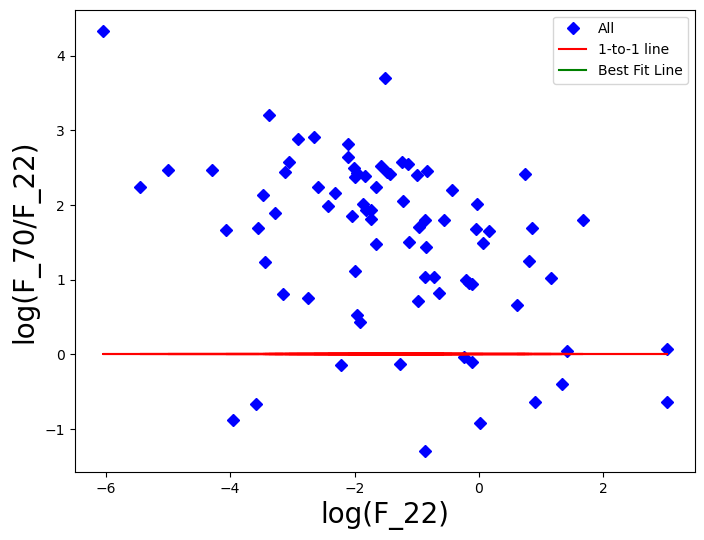

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from astropy.table import Table

# Load your data
csv_file = tabledir + '/Photometrytesting2.csv'
galaxy = Table.read(csv_file)

# Filter out rows where either 70Flux_AP06 or FLUX_AP06_W4 is 0
nonzero_indices = np.where((galaxy['70Flux_AP06'] != 0) & (galaxy['FLUX_AP06_W4'] != 0))

# Extract non-zero data
W4Flux = galaxy['FLUX_AP06_W4'][nonzero_indices] * 3.631e-6
ratio = galaxy['70Flux_AP06'][nonzero_indices] / W4Flux

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the data points with flipped axes
plt.plot(np.log(W4Flux), np.log(ratio), 'bD', markersize=6, alpha=1, label='All')

# Plot the line representing y = x
plt.plot(np.log(W4Flux), np.log(np.ones_like(W4Flux)), 'r-', label='1-to-1 line')

# Filter out NaN values for regression
valid_indices = ~np.isnan(ratio) & ~np.isnan(W4Flux)
x_valid = np.log(W4Flux[valid_indices])
y_valid = np.log(ratio[valid_indices])

# Calculate the best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(x_valid, y_valid)

# Plot the best fit line
x_fit = np.linspace(min(x_valid), max(x_valid), 100)
plt.plot(x_fit, intercept + slope * x_fit, 'g-', label='Best Fit Line')

plt.xlabel('log(F_22)', fontsize=20)
plt.ylabel('log(F_70/F_22)', fontsize=20)
plt.legend()
# Save the plot
plt.savefig(plotdir + '/70vs22log.png', dpi=150)

plt.show()


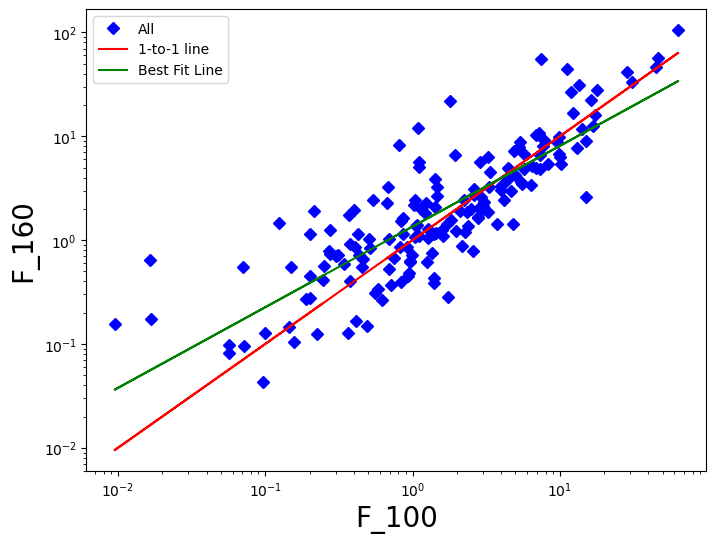

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from astropy.table import Table

# Load your data
csv_file = tabledir + '/Photometrytesting2.csv'
galaxy = Table.read(csv_file)

# Filter out data points where x-axis value is 0 or where y-axis value is NaN
nonzero_indices = np.where((galaxy['100Flux_AP06'] != 0) & (~np.isnan(galaxy['160Flux_AP06'])))

# Extract non-zero data
x = galaxy['100Flux_AP06'][nonzero_indices]
y = galaxy['160Flux_AP06'][nonzero_indices]

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the data points
plt.plot(x, y, 'bD', markersize=6, alpha=1, label='All')

# Plot the line representing y = x
plt.plot(x, x, 'r-', label='1-to-1 line')

# Filter out NaN values for regression
valid_indices = ~np.isnan(x) & ~np.isnan(y)
x_valid = x[valid_indices]
y_valid = y[valid_indices]

# Add a line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x_valid), np.log(y_valid))
plt.plot(x_valid, np.exp(intercept) * x_valid ** slope, 'g-', label='Best Fit Line')

plt.xlabel('F_100', fontsize=20)
plt.ylabel('F_160', fontsize=20)
plt.xscale('log')  # Set x-axis to log scale
plt.yscale('log')  # Set y-axis to log scale
plt.legend()

# Save the plot
plt.savefig(plotdir + '/100vs160.png', dpi=150)

plt.show()